# **Brushstroke Generator**

Loads a trained LSTM VAE, decodes fresh brushstroke trajectories, and visualises them in the t-SNE latent space.

Run the cells below top-to-bottom after updating paths and generation parameters in the configuration block.

## **Params**

In [1]:
# Imports
import re
import random
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.lines import Line2D

from openTSNE import TSNE

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# Configuration
data_dir = Path("data/cleaned_z240")
image_dir = Path("data_img")
checkpoint_path = Path("outputs/lstm_vae_checkpoint.pt")

seq_columns = ["X_mm", "Y_mm", "Z_mm", "alpha_rad", "beta_rad", "gamma_rad"]

batch_size = 16
latent_dim = 32
hidden_dim = 128
num_layers = 2
dropout = 0.1

num_generated_samples = 10
target_sample_length = 150
extra_autoreg_pad = 5
save_generated_csv = True
output_dir = Path("outputs")

tsne_perplexity = 30
tsne_max_iter = 1000
tsne_random_state = 42

## **Load Data**

In [3]:
# Inspect dataset and sequence length stats
csv_files = sorted(data_dir.glob("*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found under {data_dir.resolve()}")

lengths = [len(pd.read_csv(fp)) for fp in csv_files]
max_seq_len = max(lengths)
min_seq_len = min(lengths)
mean_seq_len = float(np.mean(lengths))

print(f"Found {len(csv_files)} motion files")
print(f"Sequence length stats -> min: {min_seq_len}, max: {max_seq_len}, mean: {mean_seq_len:.1f} timesteps")

Found 300 motion files
Sequence length stats -> min: 19, max: 233, mean: 81.0 timesteps


In [4]:
# Motion sequence dataset with sin/cos angle encoding and shared normalisation
class MotionSequenceDataset(Dataset):
    def __init__(self, files, columns, max_seq_len, stats=None):
        self.files = [Path(f) for f in files]
        self.columns = list(columns)
        self.max_seq_len = max_seq_len

        self.angle_columns = [col for col in self.columns if col.endswith("_rad")]
        self.non_angle_columns = [col for col in self.columns if col not in self.angle_columns]
        self.angle_indices = [self.columns.index(col) for col in self.angle_columns]
        self.non_angle_indices = [self.columns.index(col) for col in self.non_angle_columns]
        self.angle_count = len(self.angle_columns)
        self.non_angle_count = len(self.non_angle_columns)

        self.feature_names = list(self.non_angle_columns)
        if self.angle_count:
            self.feature_names += [f"sin_{col}" for col in self.angle_columns]
            self.feature_names += [f"cos_{col}" for col in self.angle_columns]

        raw_sequences = []
        lengths = []
        for path in self.files:
            df = pd.read_csv(path)
            seq = torch.tensor(df[self.columns].values, dtype=torch.float32)
            seq = self._encode_angles(seq)
            raw_sequences.append(seq)
            lengths.append(seq.shape[0])

        clipped = []
        effective_lengths = []
        for seq in raw_sequences:
            if seq.shape[0] > self.max_seq_len:
                clipped.append(seq[: self.max_seq_len])
                effective_lengths.append(self.max_seq_len)
            else:
                clipped.append(seq)
                effective_lengths.append(seq.shape[0])

        self.lengths = effective_lengths
        self.lengths_tensor = torch.tensor(self.lengths, dtype=torch.long)

        if stats is None:
            stacked = torch.cat(clipped, dim=0)
            mean = stacked.mean(dim=0)
            std = stacked.std(dim=0).clamp_min(1e-6)
            self.stats = (mean, std)
        else:
            mean, std = stats
            self.stats = (mean.clone(), std.clone())

        mean, std = self.stats
        normalized = []
        for seq, length in zip(clipped, self.lengths):
            padded = torch.zeros(self.max_seq_len, seq.shape[1], dtype=torch.float32)
            padded[:length] = seq
            normalized.append((padded - mean) / std)

        self.data = torch.stack(normalized)
        self.feature_dim = self.data.shape[-1]

    def _encode_angles(self, seq):
        if self.angle_count == 0:
            return seq
        non_angle = seq[:, self.non_angle_indices]
        angles = seq[:, self.angle_indices]
        sin = torch.sin(angles)
        cos = torch.cos(angles)
        return torch.cat([non_angle, sin, cos], dim=1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], torch.tensor(self.lengths[idx], dtype=torch.long)

    def denormalize(self, tensor):
        mean, std = self.stats
        mean = mean.to(tensor.device)
        std = std.to(tensor.device)
        processed = tensor * std + mean

        if self.angle_count == 0:
            return processed

        non_angle = processed[..., :self.non_angle_count]
        sin = processed[..., self.non_angle_count:self.non_angle_count + self.angle_count]
        cos = processed[..., self.non_angle_count + self.angle_count:]
        angles = torch.atan2(sin, cos)

        restored = []
        for col in self.columns:
            if col in self.non_angle_columns:
                idx = self.non_angle_columns.index(col)
                restored.append(non_angle[..., idx:idx + 1])
            else:
                idx = self.angle_columns.index(col)
                restored.append(angles[..., idx:idx + 1])
        return torch.cat(restored, dim=-1)

In [5]:
# Train/validation split with shared normalisation stats
indices = list(range(len(csv_files)))
if not indices:
    raise ValueError("No motion files available to build datasets.")

random.shuffle(indices)
split_idx = max(1, int(0.8 * len(indices)))
split_idx = min(split_idx, len(indices))
train_idx = indices[:split_idx]
val_idx = indices[split_idx:]

if not train_idx:
    train_idx = indices
    val_idx = []

train_files = [csv_files[i] for i in train_idx]
val_files = [csv_files[i] for i in val_idx]

train_dataset = MotionSequenceDataset(train_files, seq_columns, max_seq_len)
val_dataset = (
    MotionSequenceDataset(val_files, seq_columns, train_dataset.max_seq_len, stats=train_dataset.stats)
    if val_files else None
)

feature_dim = train_dataset.feature_dim
feature_names = train_dataset.feature_names

def collate_fn(batch):
    sequences, lengths = zip(*batch)
    sequences = torch.stack(sequences)
    lengths = torch.stack(lengths)
    return sequences, lengths

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
val_loader = (
    DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    if val_dataset is not None
    else None
)

train_lengths = train_dataset.lengths_tensor.float()
val_count = len(val_dataset) if val_dataset is not None else 0
print(f"Train samples: {len(train_dataset)}, Val samples: {val_count}")
print(f"Max sequence length (padded): {train_dataset.max_seq_len}")
print(f"Mean train length: {train_lengths.mean():.1f} +/- {train_lengths.std():.1f}")
print(f"Feature dimensionality after encoding: {feature_dim}")
print(f"Feature order: {feature_names}")

Train samples: 240, Val samples: 60
Max sequence length (padded): 233
Mean train length: 80.6 +/- 33.6
Feature dimensionality after encoding: 9
Feature order: ['X_mm', 'Y_mm', 'Z_mm', 'sin_alpha_rad', 'sin_beta_rad', 'sin_gamma_rad', 'cos_alpha_rad', 'cos_beta_rad', 'cos_gamma_rad']


## **Load Model**

In [6]:
# LSTM-based variational autoencoder for sequence generation
class LSTMVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_layers = num_layers

        self.encoder = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.latent_to_cell = nn.Linear(latent_dim, hidden_dim)

        self.decoder = nn.LSTM(
            input_dim + latent_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def encode(self, x, lengths):
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.encoder(packed)
        h_last = h_n[-1]
        mu = self.fc_mu(h_last)
        logvar = self.fc_logvar(h_last)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, x, z, lengths):
        batch_size, seq_len, _ = x.shape
        h0 = self.latent_to_hidden(z).unsqueeze(0).repeat(self.num_layers, 1, 1)
        c0 = self.latent_to_cell(z).unsqueeze(0).repeat(self.num_layers, 1, 1)
        z_seq = z.unsqueeze(1).expand(-1, seq_len, -1)
        decoder_input = torch.cat([x, z_seq], dim=-1)
        packed = pack_padded_sequence(decoder_input, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.decoder(packed, (h0, c0))
        output, _ = pad_packed_sequence(packed_output, batch_first=True, total_length=seq_len)
        return self.output_layer(output)

    def forward(self, x, lengths):
        mu, logvar = self.encode(x, lengths)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(x, z, lengths)
        return recon, mu, logvar

    def generate(self, z, lengths):
        if not torch.is_tensor(lengths):
            lengths = torch.tensor(lengths, device=z.device, dtype=torch.long)
        else:
            lengths = lengths.to(device=z.device, dtype=torch.long)
        batch_size = z.size(0)
        max_len = int(lengths.max().item())
        hidden = self.latent_to_hidden(z).unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell = self.latent_to_cell(z).unsqueeze(0).repeat(self.num_layers, 1, 1)
        outputs = []
        prev_output = torch.zeros(batch_size, self.input_dim, device=z.device)
        for step_idx in range(max_len):
            decoder_input = torch.cat([prev_output, z], dim=-1).unsqueeze(1)
            out, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            step_output = self.output_layer(out.squeeze(1))
            outputs.append(step_output)
            prev_output = step_output
        outputs = torch.stack(outputs, dim=1)
        for idx, length in enumerate(lengths):
            length_val = int(length.item())
            if length_val <= 0:
                continue
            if length_val < max_len:
                outputs[idx, length_val:] = outputs[idx, length_val - 1]
        return outputs

In [7]:
# Instantiate model and load trained weights
model = LSTMVAE(
    input_dim=feature_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    num_layers=num_layers,
    dropout=dropout,
).to(device)

if not checkpoint_path.exists():
    raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path.resolve()}")

checkpoint = torch.load(checkpoint_path, map_location=device)
state_dict = checkpoint.get("model_state_dict", checkpoint)
model.load_state_dict(state_dict)
model.eval()
print(f"Loaded model weights from {checkpoint_path}")

Loaded model weights from outputs\lstm_vae_checkpoint.pt


## **Visualize t-SNE Latent Space**

In [8]:
# Helper functions for latent collection and t-SNE visualisation
tsne_state = globals().get("tsne_state", {
    'embedding': None,
    'base_latent': None,
    'base_coords': None,
    'base_labels': None,
    'base_sample_ids': None,
    'perplexity': None,
    'random_state': None,
})
globals()['tsne_state'] = tsne_state


def collect_latent_embeddings(include_generated=False):
    model.eval()
    splits = [('train', train_dataset), ('val', val_dataset)]
    embeddings, labels, sample_ids = [], [], []

    with torch.no_grad():
        for split_name, dataset in splits:
            if not dataset:
                continue
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
            dataset_files = getattr(dataset, 'files', None)
            file_stems = [Path(f).stem for f in dataset_files] if dataset_files else None
            offset = 0
            for sequences, lengths in loader:
                sequences, lengths = sequences.to(device), lengths.to(device)
                mu, _ = model.encode(sequences, lengths)
                emb = mu.detach().cpu()
                n = emb.shape[0]
                embeddings.append(emb)
                labels.extend([split_name] * n)
                if file_stems:
                    sample_ids.extend(file_stems[offset:offset + n])
                    offset += n
                else:
                    sample_ids.extend([''] * n)

    if not embeddings:
        raise ValueError('No latent embeddings available for t-SNE plot. Ensure datasets and model weights are loaded.')

    base_latent = torch.cat(embeddings, dim=0).numpy().astype(np.float32)
    if base_latent.shape[0] <= 2:
        raise ValueError('Need more than two samples to compute t-SNE.')

    base_labels = np.array(labels)
    base_sample_ids = np.array(sample_ids)
    data = {
        'base_latent': base_latent,
        'base_labels': base_labels,
        'base_sample_ids': base_sample_ids,
        '_generated_ids_tuple': (),
    }

    if include_generated and 'generated_metadata' in globals():
        latent = np.asarray(generated_metadata.get('latent', []), dtype=np.float32)
        if latent.size:
            stems = [Path(p).stem for p in generated_metadata.get('paths', [])]
            if len(stems) != latent.shape[0]:
                stems = [f'generated_{i}' for i in range(latent.shape[0])]
            data['generated_latent'] = latent
            data['generated_labels'] = np.full(latent.shape[0], 'generated')
            data['generated_sample_ids'] = np.array(stems)
            data['_generated_ids_tuple'] = tuple(stems)
    data['_include_generated'] = bool(include_generated)
    return data


def plot_tsne_img(embeddings, perplexity=30, max_iter=1000, random_state=42, plot_img=False,
                  image_dir=Path('data_img'), image_zoom=0.015, include_generated=False,
                  force_refit=False, show_legend=True):

    include_generated = include_generated and embeddings.get('_include_generated', False)

    base_latent = np.asarray(embeddings['base_latent'], dtype=np.float32)
    base_labels = np.array(embeddings['base_labels'])
    base_sample_ids = np.array(embeddings['base_sample_ids'])

    if base_latent.shape[0] <= 2:
        raise ValueError('Need more than two samples to compute t-SNE.')

    effective_perplexity = min(perplexity, max(5, base_latent.shape[0] - 1))
    n_iter = max(250, max_iter)

    needs_refit = (
        force_refit
        or tsne_state['embedding'] is None
        or tsne_state['perplexity'] != effective_perplexity
        or tsne_state['random_state'] != random_state
        or tsne_state['base_latent'] is None
        or tsne_state['base_latent'].shape != base_latent.shape
        or not np.allclose(tsne_state['base_latent'], base_latent)
    )

    if needs_refit:
        tsne = TSNE(
            n_components=2,
            perplexity=effective_perplexity,
            metric='euclidean',
            random_state=random_state,
            initialization='pca',
            n_iter=n_iter,
        )
        embedding = tsne.fit(base_latent)
        base_coords = np.asarray(embedding)
        tsne_state.update({
            'embedding': embedding,
            'base_latent': base_latent.copy(),
            'base_coords': base_coords.copy(),
            'base_labels': base_labels,
            'base_sample_ids': base_sample_ids,
            'perplexity': effective_perplexity,
            'random_state': random_state,
            'n_iter': n_iter,
        })
    else:
        embedding = tsne_state['embedding']
        base_coords = tsne_state['base_coords']
        base_labels = tsne_state['base_labels']
        base_sample_ids = tsne_state['base_sample_ids']

    plot_coords = [base_coords]
    plot_labels = [base_labels]
    plot_ids = [base_sample_ids]

    generated_latent = None
    generated_labels = None
    generated_sample_ids = None
    if include_generated:
        generated_latent = embeddings.get('generated_latent')
        generated_labels = embeddings.get('generated_labels')
        generated_sample_ids = embeddings.get('generated_sample_ids')
        if generated_latent is not None and generated_latent.size:
            new_coords = np.asarray(embedding.transform(generated_latent, perplexity=effective_perplexity))
            plot_coords.append(new_coords)
            plot_labels.append(generated_labels)
            plot_ids.append(generated_sample_ids)

    coords = np.vstack(plot_coords)
    labels = np.concatenate(plot_labels)
    sample_ids = np.concatenate(plot_ids)

    image_dir = Path(image_dir)
    color_map = {'train': '#1f77b4', 'val': '#ff7f0e', 'generated': '#d62728'}

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.scatter(coords[:, 0], coords[:, 1], marker='x', s=5, linewidths=0.5, alpha=0)

    def resolve_image_path(sample_id: str):
        if not sample_id:
            return None
        candidates = []
        digits = re.findall(r'\d+', sample_id)
        for d in reversed(digits):
            try:
                num = int(d)
            except ValueError:
                continue
            candidates.extend([f'Data-{num}', f'Data-{num:02d}', f'Data-{num:03d}', f'Data-{num:04d}'])
        candidates.extend([sample_id, sample_id.replace(' ', '_')])
        seen = set()
        for base_name in candidates:
            if base_name in seen:
                continue
            seen.add(base_name)
            p = image_dir / f'{base_name}.png'
            if p.exists():
                return p
        matches = sorted(image_dir.glob(f'*{sample_id}*.png'))
        return matches[0] if matches else None

    legend_handles, legend_labels = [], []
    for split_name in sorted(set(labels)):
        mask = (labels == split_name)
        split_coords = coords[mask]
        split_ids = sample_ids[mask]
        color = color_map.get(split_name, '#555555')
        count = int(mask.sum())

        if split_name == 'generated':
            for idx_local, ((x_coord, y_coord), sid) in enumerate(zip(split_coords, split_ids)):
                digits = re.findall(r"\d+", sid) if isinstance(sid, str) else []
                label_text = digits[-1] if digits else str(idx_local)
                ax.text(
                    x_coord,
                    y_coord,
                    label_text,
                    fontsize=9,
                    fontweight='bold',
                    color=color,
                    ha='center',
                    va='center',
                )
            legend_handles.append(Line2D([0], [0], marker='s', linestyle='', markersize=8,
                                         markerfacecolor='none', markeredgecolor=color, color=color))
            legend_labels.append(f"{split_name} ({count})")
            continue

        if not plot_img:
            handle = ax.scatter(split_coords[:, 0], split_coords[:, 1],
                                marker='x', s=35, linewidths=1.1, alpha=0.8, color=color)
            legend_handles.append(handle)
            legend_labels.append(f"{split_name} ({count})")
        else:
            for (x_coord, y_coord), sid in zip(split_coords, split_ids):
                img_path = resolve_image_path(sid)
                if img_path is None:
                    ax.scatter(x_coord, y_coord, marker='x', s=35, linewidths=1.1, alpha=0.8, color=color)
                    continue
                image = plt.imread(img_path)
                ann = AnnotationBbox(OffsetImage(image, zoom=image_zoom),
                                     (x_coord, y_coord), frameon=False, zorder=1)
                ax.add_artist(ann)
            legend_handles.append(Line2D([0], [0], marker='x', linestyle='', markersize=8, color=color))
            legend_labels.append(f"{split_name} ({count})")

    if show_legend and legend_handles:
        ax.legend(legend_handles, legend_labels, loc='best', frameon=False)

    ax.set_title('t-SNE projection of latent space')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.grid(True, color='b', linewidth=0.6, alpha=0.08, zorder=10)
    plt.show()

In [9]:
# Collect baseline latent embeddings (without generated samples)
tsne_embeddings = collect_latent_embeddings(include_generated=False)
unique_labels, counts = np.unique(tsne_embeddings['base_labels'], return_counts=True)
print({label: int(count) for label, count in zip(unique_labels, counts)})

{'train': 240, 'val': 60}


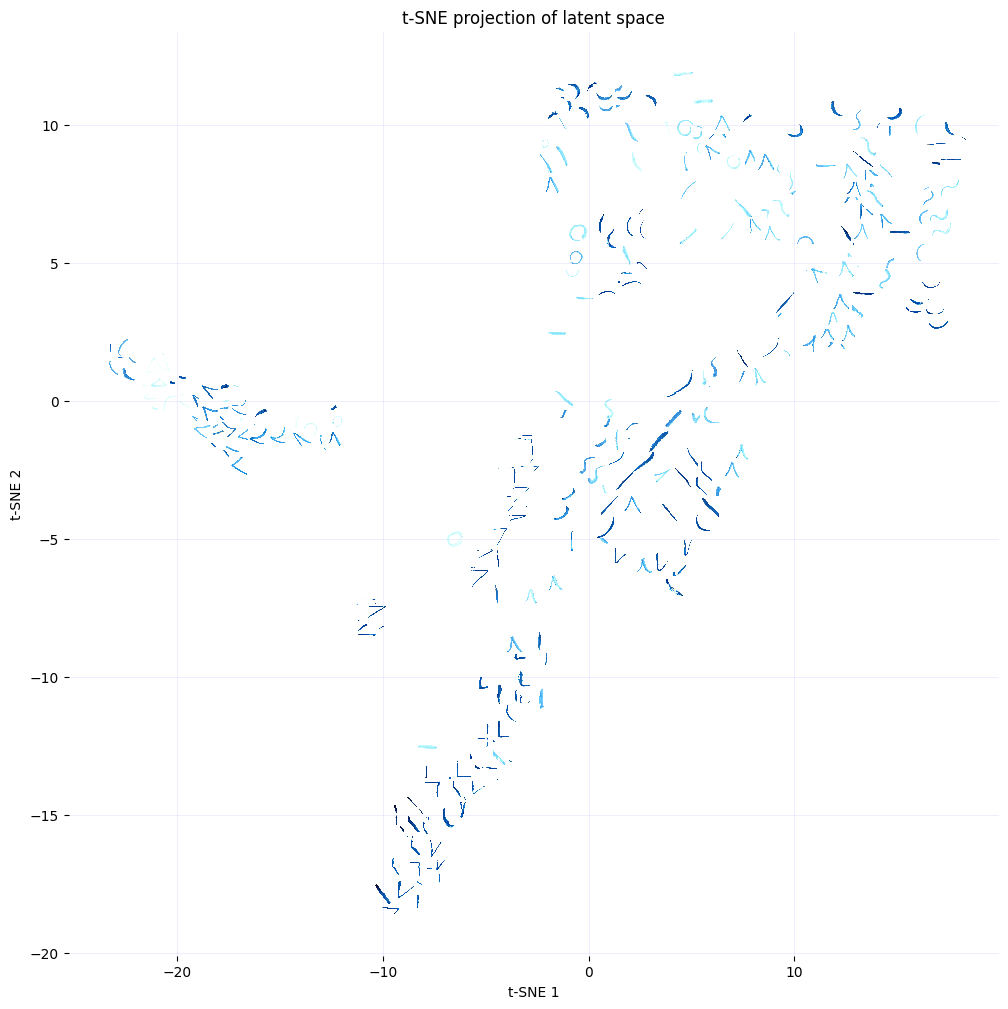

In [10]:
# Overlay dataset thumbnails in latent space
plot_tsne_img(
    tsne_embeddings,
    perplexity=tsne_perplexity,
    max_iter=tsne_max_iter,
    random_state=tsne_random_state,
    plot_img=True,
    image_dir=image_dir,
    include_generated=False,
    show_legend=False,
)

## **Generate Brushstrokes**

In [16]:
# Generation helper with configurable sequence length
def generate_brushstrokes(num_samples, sample_length=None, extra_pad=0, save_csv=True):
    if num_samples <= 0:
        raise ValueError('num_samples must be positive.')
    if len(train_dataset) == 0:
        raise ValueError('Training dataset is empty; cannot generate samples.')

    model.eval()
    random_lengths = random.choices(train_dataset.lengths, k=num_samples)
    if sample_length is None:
        base_lengths = random_lengths
    else:
        base_lengths = [int(sample_length)] * num_samples

    base_lengths = [max(1, min(train_dataset.max_seq_len, int(l))) for l in base_lengths]
    extra_pad = max(0, int(extra_pad))
    padded_lengths = [min(train_dataset.max_seq_len, length + extra_pad) for length in base_lengths]

    lengths_tensor = torch.tensor(padded_lengths, device=device, dtype=torch.long)

    with torch.no_grad():
        latent_samples = torch.randn(num_samples, latent_dim, device=device)
        decoded_sequences = model.generate(latent_samples, lengths_tensor)
        decoded_sequences = train_dataset.denormalize(decoded_sequences.cpu())

    output_dir.mkdir(parents=True, exist_ok=True)
    latent_cpu = latent_samples.detach().cpu().numpy()
    generated_filepaths = []
    effective_lengths = []
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    for idx, (base_len, padded_len) in enumerate(zip(base_lengths, padded_lengths)):
        effective_pad = max(0, padded_len - base_len)
        start = effective_pad
        end = start + base_len
        seq = decoded_sequences[idx, start:end].numpy()
        effective_lengths.append(int(seq.shape[0]))

        if save_csv:
            output_path = output_dir / f"brushstroke_sample_{timestamp}_{idx}.csv"
            pd.DataFrame(seq, columns=seq_columns).to_csv(output_path, index=False)
            generated_filepaths.append(str(output_path))
            print(f"Generated sample {idx} saved to {output_path} (length {seq.shape[0]})")
        else:
            generated_filepaths.append('')
            print(f"Generated sample {idx} (length {seq.shape[0]})")

    metadata = {
        'paths': generated_filepaths,
        'latent': latent_cpu,
        'lengths': effective_lengths,
        'base_lengths': base_lengths,
        'extra_pad': extra_pad,
    }
    globals()['generated_metadata'] = metadata
    return metadata

In [18]:
# Generate new brushstrokes with the configured parameters
generated_metadata = generate_brushstrokes(
    num_generated_samples,
    sample_length=target_sample_length,
    extra_pad=extra_autoreg_pad,
    save_csv=save_generated_csv,
)
print(f"Generated metadata keys: {list(generated_metadata.keys())}")

Generated sample 0 saved to outputs\brushstroke_sample_20251028_145333_0.csv (length 150)
Generated sample 1 saved to outputs\brushstroke_sample_20251028_145333_1.csv (length 150)
Generated sample 2 saved to outputs\brushstroke_sample_20251028_145333_2.csv (length 150)
Generated sample 3 saved to outputs\brushstroke_sample_20251028_145333_3.csv (length 150)
Generated sample 4 saved to outputs\brushstroke_sample_20251028_145333_4.csv (length 150)
Generated sample 5 saved to outputs\brushstroke_sample_20251028_145333_5.csv (length 150)
Generated sample 6 saved to outputs\brushstroke_sample_20251028_145333_6.csv (length 150)
Generated sample 7 saved to outputs\brushstroke_sample_20251028_145333_7.csv (length 150)
Generated sample 8 saved to outputs\brushstroke_sample_20251028_145333_8.csv (length 150)
Generated sample 9 saved to outputs\brushstroke_sample_20251028_145333_9.csv (length 150)
Generated metadata keys: ['paths', 'latent', 'lengths', 'base_lengths', 'extra_pad']


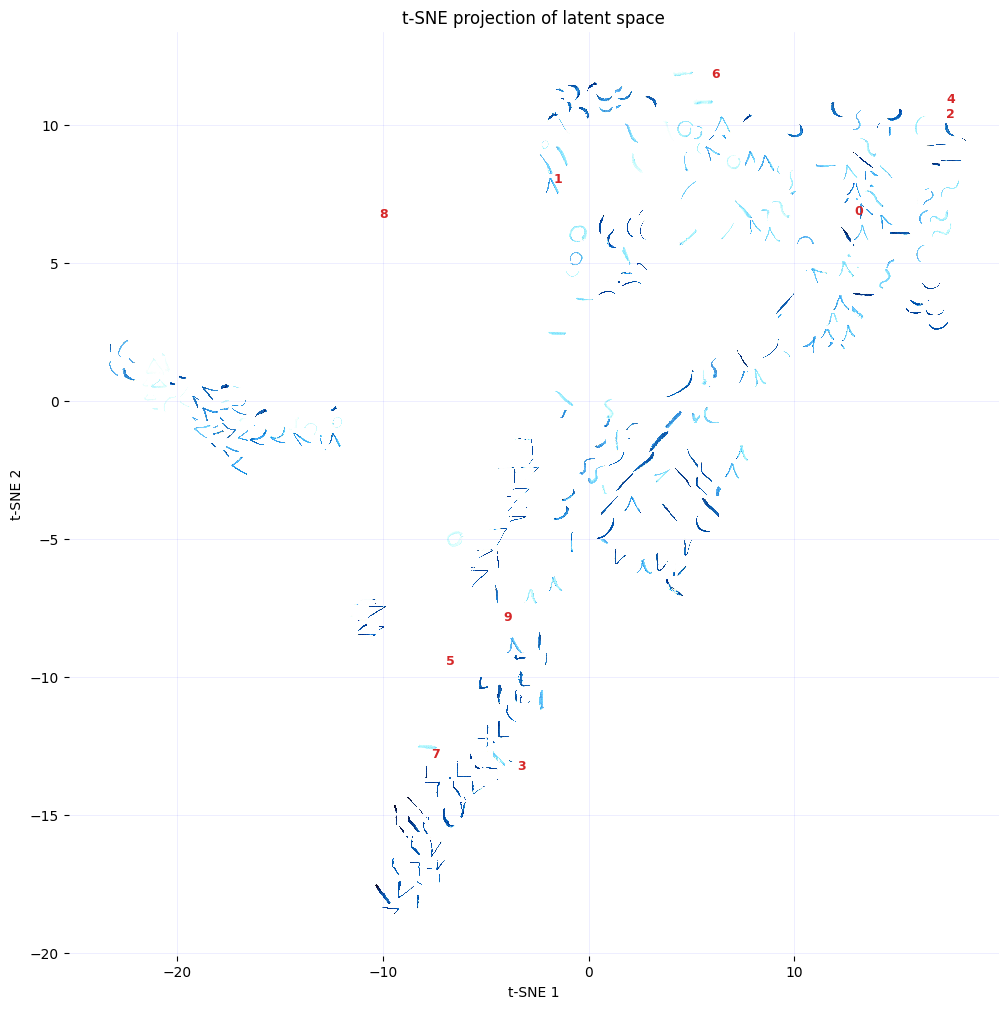

In [19]:
# Recompute embeddings including generated samples and overlay on t-SNE
tsne_embeddings = collect_latent_embeddings(include_generated=True)

plot_tsne_img(
    tsne_embeddings,
    perplexity=tsne_perplexity,
    max_iter=tsne_max_iter,
    random_state=tsne_random_state,
    plot_img=True,
    image_dir=image_dir,
    include_generated=True,
    show_legend=False,
)